<a href="https://colab.research.google.com/github/utegenf/image_classification/blob/main/Image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Download and explore the dataset**

In [1]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d defileroff/comic-faces-paired-synthetic-v2
! unzip comic-faces-paired-synthetic-v2.zip

Streaming output truncated to the last 5000 lines.
  inflating: face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/faces/5503.jpg  
  inflating: face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/faces/5504.jpg  
  inflating: face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/faces/5505.jpg  
  inflating: face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/faces/5506.jpg  
  inflating: face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/faces/5507.jpg  
  inflating: face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/faces/5508.jpg  
  inflating: face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/faces/5509.jpg  
  inflating: face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/faces/551.jpg  
  inflating: face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/faces/5510.jpg  
  inflating: face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/faces/5511.jpg  
  inflating: face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/faces/5512.jpg  
  in

In [28]:
!rm -rf face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/samples
!ls face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/

comics	faces


In [38]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

data_dir = '/content/face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela'

**Create a dataset**

In [39]:
batch_size = 64
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 20000 files belonging to 2 classes.
Using 16000 files for training.


In [40]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 20000 files belonging to 2 classes.
Using 4000 files for validation.


In [41]:
class_names = train_ds.class_names
print(class_names)

['comics', 'faces']


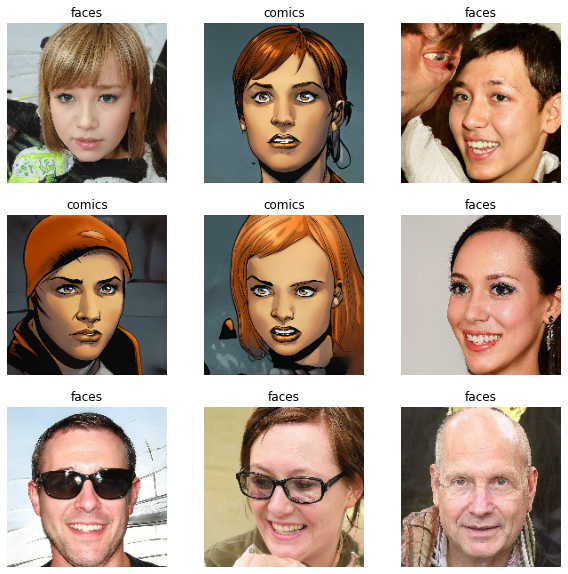

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [43]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 180, 180, 3)
(64,)


In [44]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [45]:
normalization_layer = layers.Rescaling(1./255)

In [46]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


**Data Augmentation**

In [47]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

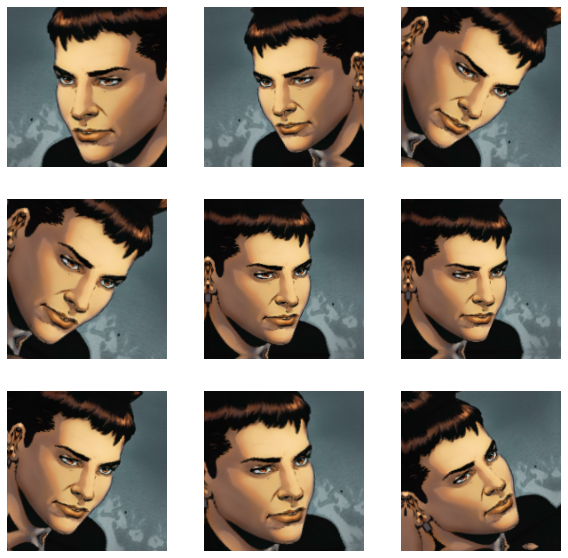

In [48]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

**Create and compile the model**

In [49]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

**Train the model**

In [50]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
250/250 [==============================] - 561s 2s/step - loss: 0.0852 - accuracy: 0.9731 - val_loss: 0.0969 - val_accuracy: 0.9760
Epoch 2/10
250/250 [==============================] - 534s 2s/step - loss: 0.0051 - accuracy: 0.9980 - val_loss: 0.0564 - val_accuracy: 0.9858
Epoch 3/10
250/250 [==============================] - 529s 2s/step - loss: 0.0063 - accuracy: 0.9984 - val_loss: 0.0010 - val_accuracy: 0.9998
Epoch 4/10
250/250 [==============================] - 528s 2s/step - loss: 0.0022 - accuracy: 0.9993 - val_loss: 0.0655 - val_accuracy: 0.9850
Epoch 5/10
250/250 [==============================] - 525s 2s/step - loss: 0.0075 - accuracy: 0.9973 - val_loss: 0.0057 - val_accuracy: 0.9983
Epoch 6/10
250/250 [==============================] - 524s 2s/step - loss: 0.0024 - accuracy: 0.9991 - val_loss: 0.0079 - val_accuracy: 0.9980
Epoch 7/10
250/250 [==============================] - 524s 2s/step - loss: 0.0060 - accuracy: 0.9980 - val_loss: 0.0013 - val_accuracy: 0.9998

**Visualize training results**

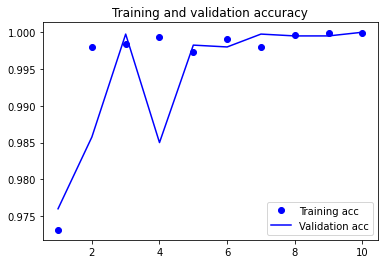

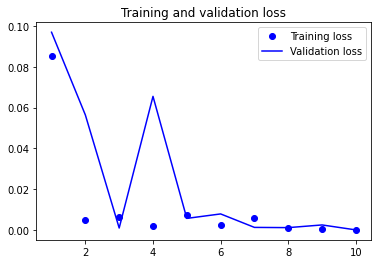

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**Predict on new data**

  98304/Unknown - 0s 1us/step

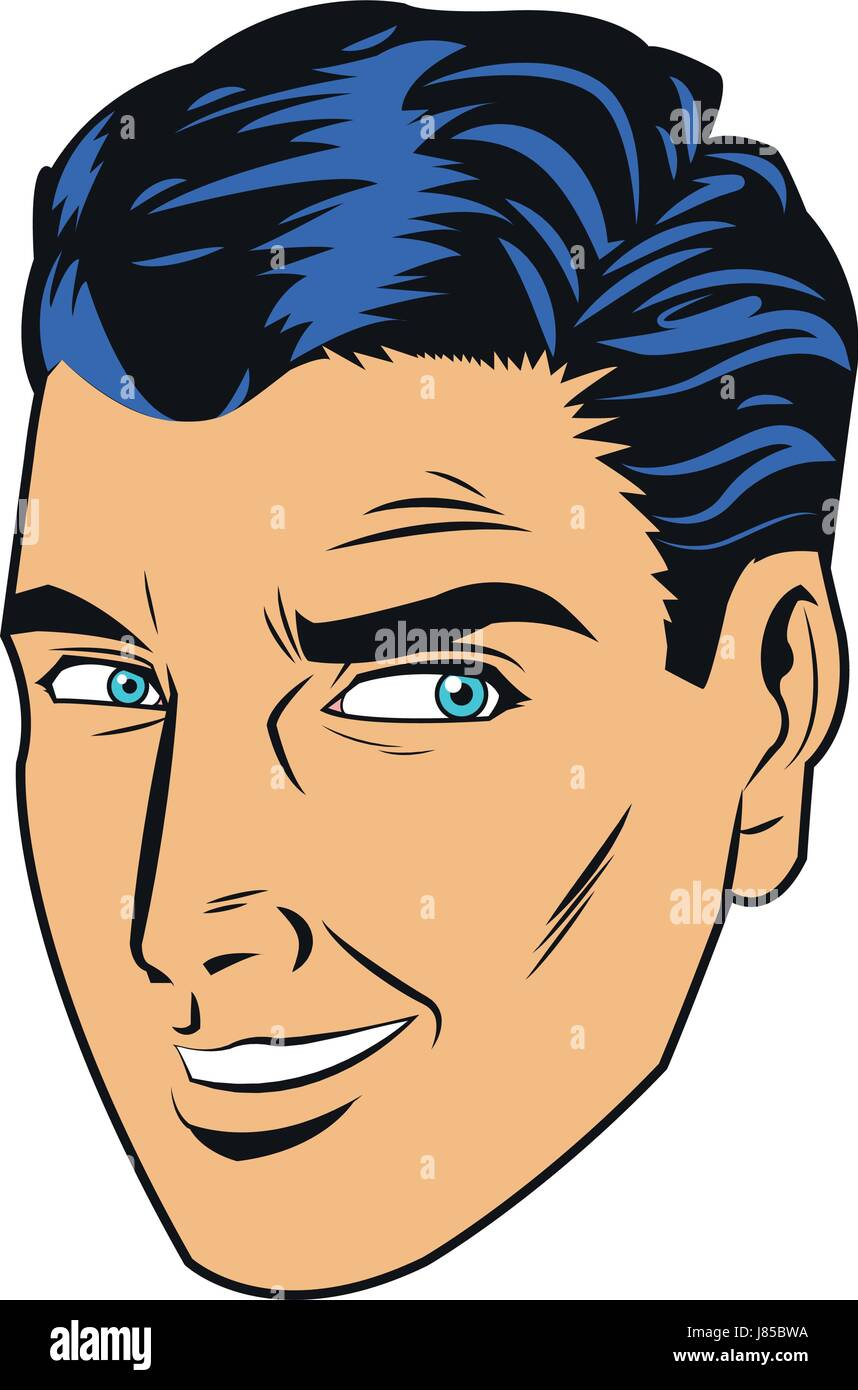

In [60]:
comic_url = "https://c8.alamy.com/comp/J85BWA/comic-face-man-expression-pop-art-style-J85BWA.jpg"
comic_path = tf.keras.utils.get_file('comic-face-man-expression-pop-art-style-J85BWA', origin=comic_url)

import IPython
IPython.display.Image(comic_url, width = 250)

In [61]:
img = tf.keras.utils.load_img(
    comic_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to comics with a 100.00 percent confidence.


This image most likely belongs to comics with a 100.00 percent confidence.

32768/23962 [=========================================] - 0s 0us/step


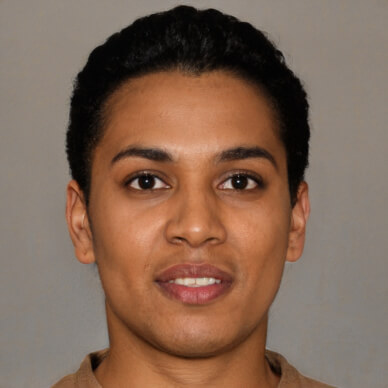

In [54]:
face_url = "https://static.generated.photos/vue-static/face-generator/landing/wall/12.jpg"
face_path = tf.keras.utils.get_file('12', origin=face_url)

import IPython
IPython.display.Image(face_url, width = 250)

In [55]:
img1 = tf.keras.utils.load_img(
    face_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img1)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to faces with a 99.99 percent confidence.


This image most likely belongs to faces with a 99.99 percent confidence.